## 1. Cargamos librerías y el dataset

In [6]:
# Importamos las librerías necesarias
import pandas as pd
#import geopandas
#import shapely.wkt
#import rtree
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_rows = 100
%matplotlib inline
pd.set_option("display.max_rows", 101)

In [7]:
# Levantamos el dataset
propiedades_original = pd.read_csv("properatti.csv"
           , encoding = 'utf-8')

In [8]:
# Asignamos el dataset original a uno nuevo sobre el cual vamos a trabajar
propiedades = propiedades_original

In [9]:
# Revisamos las medianas por barrio y tipo de propiedad
propiedades2 = propiedades[['place_name', 'property_type','price_aprox_usd']].groupby(['place_name', 'property_type']).aggregate([np.median])
propiedades2

price_aprox_usd
                                                          median
place_name                         property_type                
 Country Maschwitz Club            house              320000.000
 los alamos                        apartment           81600.000
9 de Abril                         house              110000.000
                                   store              350000.000
Abasto                             PH                 160000.000
                                   apartment          118000.000
                                   house              142000.000
                                   store              380000.000
Abril Club de Campo                house              780000.000
Acacias Blancas                    house              227500.000
Acassuso                           PH                 270000.000
                                   apartment          267500.000
                                   house              550000.000
                                   store              372500.000
Achiras                            apartment                 NaN
                                   house              100000.000
                                   store                     NaN
Adolfo Alsina                      house                     NaN
Adrogué                            PH                 150000.000
                                   apartment          150000.000
                                   house              260000.000
                                   store              220000.000
Aeropuerto Internacional Ezeiza    house              250000.000
Agronomía                          PH                 210000.000
                                   apartment          127000.000
                                   house              432500.000
                                   store              420000.000
Agua Blanca                        house              126000.000
Agua de Oro                        house              190000.000
Aguas Verdes                       PH                  57500.000
                                   apartment           60000.000
                                   house               75000.000
Albanueva Barrio Cerrado           apartment          486000.000
                                   house             1280000.000
Aldea Brasilera                    house              130000.000
Aldea Salto                        house                     NaN
Aldo Bonzi                         house              150000.000
                                   store              125000.000
Alejandro Korn                     apartment          350000.000
                                   house              122500.000
                                   store              210000.000
Alejandro Roca                     house             1250000.000
Alem                               apartment           63750.000
Alfar                              house               85000.000
Almafuerte                         house               61692.040
Almagro                            PH                 220000.000
                                   apartment          125000.000
                                   house              450000.000
                                   store              185000.000
Almirante Brown                    PH                 182500.000
...                                                          ...
Villa Soldati                      store             4305555.500
Villa Tesei                        apartment           60000.000
                                   house               96500.000
                                   store               50000.000
Villa Udaondo                      PH                 130000.000
                                   apartment          100000.000
                                   house              240000.000
Villa Unión                        apartment                 NaN
Villa Urquiza      

In [10]:
# Nos quedamos con capital federal

propiedades = propiedades.drop(propiedades[propiedades.state_name!='Capital Federal'].index)

# Reemplazamos por la mediana en los campos cuyo precio en dólares sea NAN (este paso tarda unos minutos)
def completa_nan(valor, str_place_name,str_property_type):
    df2 = propiedades.loc[(propiedades['place_name'] == str_place_name) & (propiedades['property_type'] == str_property_type)]
    return df2.price_aprox_usd.median()

# Pruebita
#completa_nan(np.nan,"Abasto","PH")
propiedades["price_aprox_usd"] = propiedades["price_aprox_usd"].apply(lambda X: completa_nan(X, propiedades.place_name, propiedades.property_type) if np.isnan(X) else X)

## 7. Preguntas al Dataset de Properatti

### 7.1 ¿En cuáles barrios de *Capital Federal* pueden encontrarse propiedades en venta, del tipo *Departamento* y por debajo del monto total de *60.000 dólares*?

In [11]:
#Seteo de parámetros de consulta:
state_name_filter = 'Capital Federal'
property_type_filter = 'apartment'
price_filter = 60000

In [12]:
propiedades.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32316 entries, 0 to 121219
Data columns (total 26 columns):
Unnamed: 0                    32316 non-null int64
operation                     32316 non-null object
property_type                 32316 non-null object
place_name                    32316 non-null object
place_with_parent_names       32316 non-null object
country_name                  32316 non-null object
state_name                    32316 non-null object
geonames_id                   31030 non-null float64
lat-lon                       23770 non-null object
lat                           23770 non-null float64
lon                           23770 non-null float64
price                         29018 non-null float64
currency                      29018 non-null object
price_aprox_local_currency    29018 non-null float64
price_aprox_usd               32316 non-null float64
surface_total_in_m2           26437 non-null float64
surface_covered_in_m2         29977 non-null float64

In [13]:
#definimos la variable null columns
null_columns=propiedades.columns[propiedades.isnull().any()]
print(propiedades[null_columns].isnull().sum())

geonames_id                    1286
lat-lon                        8546
lat                            8546
lon                            8546
price                          3298
currency                       3298
price_aprox_local_currency     3298
surface_total_in_m2            5879
surface_covered_in_m2          2339
price_usd_per_m2               8882
price_per_m2                   4992
floor                         29307
rooms                         16991
expenses                      25724
image_thumbnail                 488
dtype: int64


In [14]:
# Vemos las filas a las que le faltan el precio
# Para mejorar la síntesis de nuestro análisis vamos a considerar solamente los barrios en Capital Federal
# También vamos a cambiar el #Nan# de los precios de la siguiente forma. Para que los valores faltantes 
# sean representativos en relacion a la muestra que tenemos; ante valores de distribución normal usaremos la media, 
# pero si la muestra tiene una distribución heterogénea usaremos la mediana
propiedades_en_zona = propiedades.drop(propiedades[propiedades.state_name!=state_name_filter].index)
propiedades_en_zona.shape

(32316, 26)

In [15]:
states = propiedades_en_zona['state_name'].unique()
print(states)
print('{} elementos distintos.'.format(states.size))

['Capital Federal']
1 elementos distintos.


In [16]:
barrios = propiedades_en_zona['place_name'].unique()
print(barrios)
print('{} elementos distintos.'.format(barrios.size))

['Mataderos' 'Liniers' 'Belgrano' 'Palermo Soho' 'Palermo' 'Flores'
 'Boedo' 'Las Cañitas' 'Puerto Madero' 'Balvanera' 'Caballito' 'Nuñez'
 'San Telmo' 'Almagro' 'Capital Federal' 'Colegiales' 'Floresta'
 'Barrio Norte' 'Barracas' 'Recoleta' 'Congreso' 'Villa Crespo'
 'Chacarita' 'Constitución' 'Villa Urquiza' 'Palermo Hollywood' 'Saavedra'
 'Monserrat' 'Pompeya' 'Parque Chas' 'Paternal' 'Agronomía'
 'Villa Pueyrredón' 'Coghlan' 'Parque Centenario' 'Palermo Chico'
 'Villa Luro' 'Villa Devoto' 'Boca' 'Parque Avellaneda' 'San Cristobal'
 'Velez Sarsfield' 'Abasto' 'Versalles' 'Villa del Parque' 'Monte Castro'
 'Retiro' 'Parque Patricios' 'San Nicolás' 'Villa Santa Rita'
 'Centro / Microcentro' 'Once' 'Tribunales' 'Parque Chacabuco' 'Catalinas'
 'Villa General Mitre' 'Palermo Viejo' 'Villa Lugano' 'Villa Ortuzar'
 'Villa Soldati' 'Villa Real' 'Villa Riachuelo']
62 elementos distintos.


In [17]:
prop_type = propiedades_en_zona['property_type'].unique()
print(prop_type)
print('{} elementos distintos.'.format(prop_type.size))

['PH' 'apartment' 'house' 'store']
4 elementos distintos.


#### Cantidad total de propiedades en venta por Barrios de Capital Federal y por Tipo de Propiedades

In [18]:
#null_columns=propiedades_en_CapFed.columns[propiedades_en_CapFed.isnull().any()]
#print(propiedades_en_CapFed[null_columns].isnull().sum())
df_plot = propiedades_en_zona.groupby(['place_name', 'property_type']).size().reset_index().pivot(columns='property_type', index='place_name', values=0)
#df_plot['ventas_totales'] = df_plot.sum(axis=1)
display(df_plot)

property_type,PH,apartment,house,store
place_name,,,,
Abasto,14.0,79.0,11.0,9.0
Agronomía,7.0,29.0,4.0,1.0
Almagro,68.0,1023.0,38.0,36.0
Balvanera,36.0,584.0,10.0,37.0
Barracas,41.0,324.0,46.0,14.0
Barrio Norte,12.0,1063.0,7.0,58.0
Belgrano,43.0,2761.0,121.0,67.0
Boca,14.0,178.0,25.0,6.0
Boedo,33.0,793.0,43.0,21.0


In [19]:
propiedades_en_zona_por_tipo = propiedades_en_zona[propiedades_en_zona.property_type == property_type_filter]

print(propiedades_en_zona_por_tipo.shape)
display(propiedades_en_zona_por_tipo.sample(5))

(27037, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
10788,10788,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.570224,-58.50415",-34.570224,...,71.0,NaN,1485.211268,NaN,2.0,NaN,http://www.properati.com.ar/1690v_venta_depart...,Corredor Responsable: Ariel Champanier - C.U.C...,PRE-VENTA 2 AMBIENTES EN DUPLEX CON PATIO.,https://thumbs4.properati.com/9/aEBBAXSplWkp-R...
11482,11482,sell,apartment,Palermo Chico,|Argentina|Capital Federal|Palermo|Palermo Chico|,Argentina,Capital Federal,NaN,"-34.5772542,-58.4134322",-34.577254,...,90.0,4947.368421,5222.222222,NaN,4.0,NaN,http://www.properati.com.ar/16bte_venta_depart...,Impecable semipiso en en la mejor zona de Pale...,IMPECABLE 4 AMBIENTES C/ COCHERA FIJA Y CUB. P...,https://thumbs4.properati.com/9/j8rrALbkrWvoRY...
63094,63094,sell,apartment,Recoleta,|Argentina|Capital Federal|Recoleta|,Argentina,Capital Federal,3429595.0,"-34.598825,-58.396754",-34.598825,...,37.0,NaN,3648.648649,10.0,1.0,NaN,http://www.properati.com.ar/1a86v_venta_depart...,Corredor Responsable: Juan Carlos Treco - CUCI...,Venta Luminoso Monoambiente Vista Abierta Reco...,https://thumbs4.properati.com/7/uDUNh-CWu_DLPc...
4892,4892,sell,apartment,Barracas,|Argentina|Capital Federal|Barracas|,Argentina,Capital Federal,3436134.0,"-34.6327573,-58.3734462",-34.632757,...,70.0,1785.714286,1785.714286,NaN,3.0,NaN,http://www.properati.com.ar/15ody_venta_depart...,Tres ambientes amplio contra frente muy lumino...,"Tres amplios ambientes, contrafrente, en excel...",https://thumbs4.properati.com/6/hiYF10M_17hcwL...
30883,30883,sell,apartment,Flores,|Argentina|Capital Federal|Flores|,Argentina,Capital Federal,3433918.0,"-34.6332049777,-58.4598578492",-34.633205,...,20.0,2750.000000,2750.000000,NaN,1.0,NaN,http://www.properati.com.ar/182yd_venta_depart...,Directorio entre Membrillar y Rivera Indarte: ...,Directorio y Membrillar: Monoambiente con coci...,https://thumbs4.properati.com/5/fMv5WMTUBHJWqo...


In [20]:
departamentos_en_zona_en_precio = propiedades_en_zona_por_tipo[ \
    (propiedades_en_zona_por_tipo.property_type == property_type_filter) & \
    (propiedades_en_zona_por_tipo.price_aprox_usd.astype(float) <= float(price_filter))]

#.groupby(['place_name'])['property_type'].filter(lambda x: x['property_type'] == property_type_filter)
#df_plot['ventas_totales'] = df_plot.sum(axis=1)
#display(propiedades_en_CapFed)
#grouped.filter(lambda x: x['B'].mean() > 3.)
print(departamentos_en_zona_en_precio.shape)
display(departamentos_en_zona_en_precio.sample(5))

(676, 26)


,Unnamed: 0,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,...,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,description,title,image_thumbnail
79129,79129,sell,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Argentina,Capital Federal,3427407.0,NaN,NaN,...,NaN,1896.551724,NaN,NaN,NaN,1100.0,http://www.properati.com.ar/1av59_venta_depart...,Venta Departamento Monoambiente en Villa LuroE...,Venta Departamento Monoambiente en Villa Luro,https://thumbs4.properati.com/9/JVu-_4cMi4t-xT...
99519,99519,sell,apartment,Colegiales,|Argentina|Capital Federal|Colegiales|,Argentina,Capital Federal,3435356.0,"-34.5787213694,-58.4570952614",-34.578721,...,43.0,146.504286,2976.744186,NaN,NaN,2000.0,http://www.properati.com.ar/1bmqn_venta_depart...,Departamento en venta de dos ambientes en Cole...,Departamento - Colegiales,https://thumbs4.properati.com/7/85HwLCcRuANQsD...
102478,102478,sell,apartment,Villa Urquiza,|Argentina|Capital Federal|Villa Urquiza|,Argentina,Capital Federal,3433775.0,"-34.5756455671,-58.4864683225",-34.575646,...,107.0,170.218860,3233.644860,NaN,NaN,NaN,http://www.properati.com.ar/1bqo0_venta_depart...,Departamento 114m² con Apto profesional en Bla...,Departamento - Urquiza R,https://thumbs4.properati.com/8/EZrge1Dhj_5A1k...
106881,106881,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Argentina,Capital Federal,3430234.0,"-34.5888889,-58.4305556",-34.588889,...,25.0,1222.457419,27028.320000,NaN,NaN,NaN,http://www.properati.com.ar/1bwzj_venta_depart...,"CODIGO: ubicado en: Acuña de Figueroa, Fco.13...","Acuña de Figueroa, Fco.1332 P.1 Dto...",https://thumbs4.properati.com/9/pyyf9Hvbwtn_uo...
27163,27163,sell,apartment,Abasto,|Argentina|Capital Federal|Abasto|,Argentina,Capital Federal,NaN,NaN,NaN,...,30.0,1833.333333,1833.333333,1.0,1.0,150.0,http://www.properati.com.ar/17sfg_venta_depart...,DEPARTAMENTO DE 1 AMBIENTE EN VENTAUBICADO AL ...,DEPARTAMENTO EN VENTA,https://thumbs4.properati.com/0/hvBoVSWW3tu2bk...


In [21]:
departamentos_en_zona_en_precio = propiedades_en_zona_por_tipo[ \
    (propiedades_en_zona_por_tipo.property_type == property_type_filter) & \
    (propiedades_en_zona_por_tipo.price_aprox_usd.astype(float) <= price_filter)] \
    .groupby(['place_name', 'property_type']).size().reset_index() \
    .pivot(columns='property_type', index='place_name', values=0)
print(departamentos_en_zona_en_precio.shape)
print(departamentos_en_zona_en_precio.columns)
display(departamentos_en_zona_en_precio)

(51, 1)
Index(['apartment'], dtype='object', name='property_type')


property_type,apartment
place_name,
Abasto,6
Almagro,22
Balvanera,35
Barracas,7
Barrio Norte,9
Belgrano,6
Boca,21
Boedo,144
Caballito,28


**Conclusión:** En el período correspondiente al dataset analizado, se encuentran 676 propiedades a la *Venta* del tipo *Departamento* por debajo de los u$s60.000 especificados en la pregunta, en 51 de los 62 barrios de Capital Federal.  

In [22]:
print('**Conclusión:** En el período correspondiente al dataset analizado, se encuentran *{}* propiedades a la *Venta*' \
      ' del tipo *{}* por debajo de los *u$s{}*, en *{}* de los barrios de *{}*, según los parámetros especificados en la pregunta.' \
      .format(departamentos_en_zona_en_precio[property_type_filter].sum(), \
              property_type_filter, price_filter, \
              departamentos_en_zona_en_precio[property_type_filter].count(), \
              state_name_filter))

**Conclusión:** En el período correspondiente al dataset analizado, se encuentran *676* propiedades a la *Venta* del tipo *apartment* por debajo de los *u$s60000*, en *51* de los barrios de *Capital Federal*, según los parámetros especificados en la pregunta.


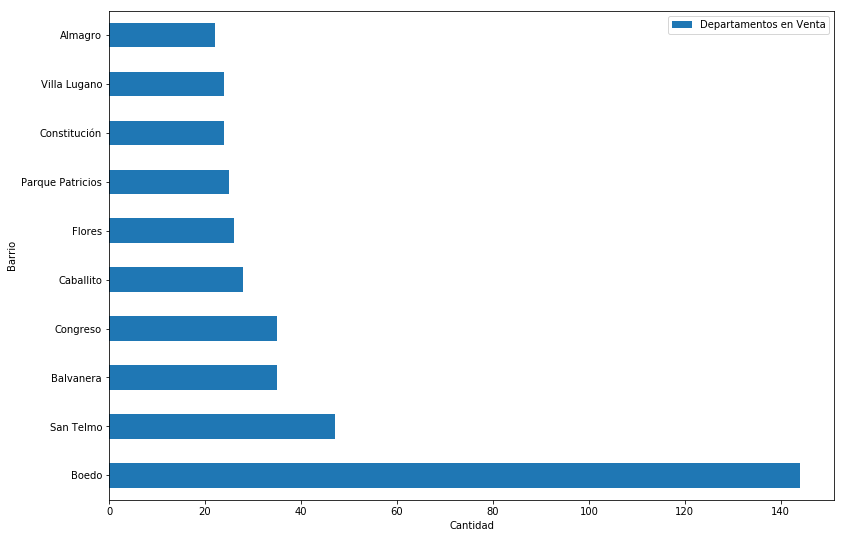

In [23]:
from matplotlib.pyplot import *
fig, ax = subplots()
departamentos_en_zona_en_precio.sort_values(by='apartment', ascending=False)[:10].plot(kind='barh', figsize=(13, 9), ax=ax)
ax.set_ylabel(ylabel="Barrio")
ax.set_xlabel(xlabel="Cantidad")
ax.legend(["Departamentos en Venta"])

### 7.2 ¿Existe y cómo es la relación entre precios de departamentos por barrios de Capital Federal y la cantidad de departamentos en venta en esa zona?

In [24]:
#Seteo de parámetros de consulta:
state_name_filter = 'Capital Federal'
property_type_filter = 'apartment'

In [25]:
# reutilizo el dataframe ya filtrado antes para 'state_name=Capital Federal' y  'property_type=apartment'
propiedades_en_zona_por_tipo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27037 entries, 2 to 121219
Data columns (total 26 columns):
Unnamed: 0                    27037 non-null int64
operation                     27037 non-null object
property_type                 27037 non-null object
place_name                    27037 non-null object
place_with_parent_names       27037 non-null object
country_name                  27037 non-null object
state_name                    27037 non-null object
geonames_id                   25950 non-null float64
lat-lon                       19446 non-null object
lat                           19446 non-null float64
lon                           19446 non-null float64
price                         24154 non-null float64
currency                      24154 non-null object
price_aprox_local_currency    24154 non-null float64
price_aprox_usd               27037 non-null float64
surface_total_in_m2           22580 non-null float64
surface_covered_in_m2         25240 non-null float64

In [26]:
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
import numpy as np

In [27]:
output_notebook()

Loading BokehJS ...

In [28]:
propiedades_en_zona_por_tipo['price_aprox_usd'] = pd.to_numeric(propiedades_en_zona_por_tipo['price_aprox_usd'], errors='coerce')

/Users/Cristian/anaconda3/envs/dsdh-data/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [29]:
propiedades_en_zona_por_tipo_grouped = propiedades_en_zona_por_tipo.groupby('place_name').price_aprox_usd.agg(['count', 'mean', 'std'])
print(propiedades_en_zona_por_tipo_grouped.shape)
print(propiedades_en_zona_por_tipo_grouped.info())
display(propiedades_en_zona_por_tipo_grouped.head())

(62, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 62 entries, Abasto to Villa del Parque
Data columns (total 3 columns):
count    62 non-null int64
mean     62 non-null float64
std      61 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1.9+ KB
None


,count,mean,std
place_name,,,
Abasto,79,126091.795823,60376.481109
Agronomía,29,131051.620690,38900.071883
Almagro,1023,153232.211202,105748.302960
Balvanera,584,133470.004726,87029.080133
Barracas,324,164251.301698,118746.468347


In [30]:
from bokeh.plotting import figure, show , output_file
from bokeh.models import ColumnDataSource, Range1d, LabelSet, Label, NumeralTickFormatter
from bokeh.layouts import gridplot

output_file("barplot.html", title="Relación Precios y Cantidades en Venta")

data_bokeh = ColumnDataSource(propiedades_en_zona_por_tipo_grouped)

options = {'plot_width': 900,
           'plot_height': 600,
           'tools': 'pan,wheel_zoom,box_zoom,box_select,lasso_select, reset'}

p1 = figure(title="Relación Precios y Cantidades en Venta por Barrio", **options)
p1.circle("count", "mean", color="blue", source = data_bokeh)

p2 = figure(title="Dispersión de Precios Aprox. en relación con las Cantidades en Venta por Barrio", **options)
p2.circle("count", "std", color="green", source = data_bokeh)

labels = LabelSet(x='count', y='mean', text='place_name', text_font_size="8pt", text_color="orange", level='glyph',
              x_offset=5, y_offset=3, source=data_bokeh, render_mode='canvas')
citation = Label(x=70, y=270, x_units='screen', y_units='screen',
                 text='.+ Dataset Properatti 2017 +.', render_mode='css',
                 border_line_color='black', border_line_alpha=1.0,
                 background_fill_color='white', background_fill_alpha=1.0)

p1.add_layout(labels)
p1.add_layout(citation)
p1.yaxis.formatter = NumeralTickFormatter(format="00")
p1.yaxis.axis_label = "Precio Aprox en Dólares"
p1.xaxis.axis_label = "Departamentos en Venta"

show(p1)